In [72]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
adata = sc.read_10x_mtx('/Users/koheisanno/Documents/School/COS521_Final/droplet/Mammary_Gland-10X_P7_12/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols (stored within the .mtx file along w/ the UMIs) for the variable names (variables-axis index)
    
    cache=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [74]:
# proprocessing: filter out genes expressed in less than 3 cells and cells expressing less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_ol

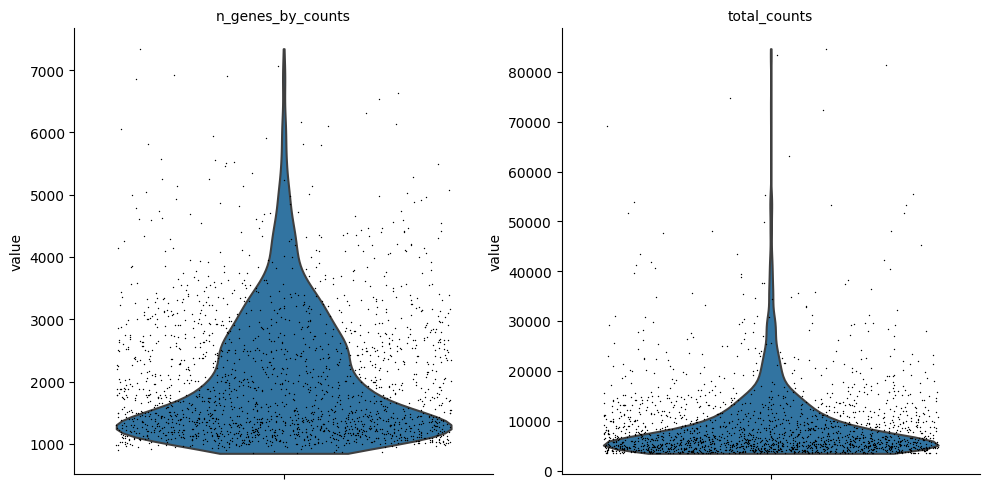

In [75]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [76]:
print(f'Before filtering: {adata.X.shape}')

adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.n_genes_by_counts > 900, :]
print(f'After filtering: {adata.X.shape}')

Before filtering: (1938, 15086)
After filtering: (1929, 15086)


In [77]:
adata.X = sc.pp.normalize_total(adata, inplace=False, target_sum=10000)["X"]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [78]:
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000) 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:72: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


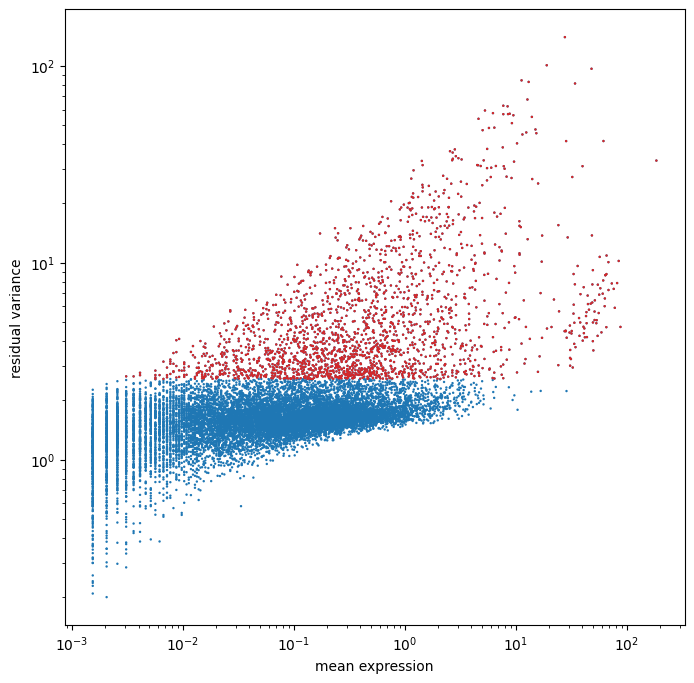

In [79]:
hvgs = adata.var["highly_variable"]

plt.figure(figsize=(8,8))
plt.scatter(adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none")
plt.scatter( 
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("mean expression")
plt.ylabel("residual variance")

plt.show()

In [80]:
sc.pp.scale(adata.X)

array([[-0.10729611, -0.5374015 , -0.3689838 , ..., -0.06077693,
        -0.07478279,  0.07401874],
       [-0.10729611,  0.65473735, -0.3689838 , ..., -0.06077693,
        -0.07478279, -0.0904404 ],
       [-0.10729611, -0.5374015 , -0.3689838 , ..., -0.06077693,
        -0.07478279,  3.6097095 ],
       ...,
       [-0.10729611,  1.518575  , -0.3689838 , ..., -0.06077693,
        -0.07478279, -0.67163366],
       [-0.10729611, -0.5374015 , -0.3689838 , ..., -0.06077693,
        -0.07478279,  0.873538  ],
       [-0.10729611,  0.55336386,  0.9755578 , ..., -0.06077693,
        -0.07478279, -0.67163366]], dtype=float32)

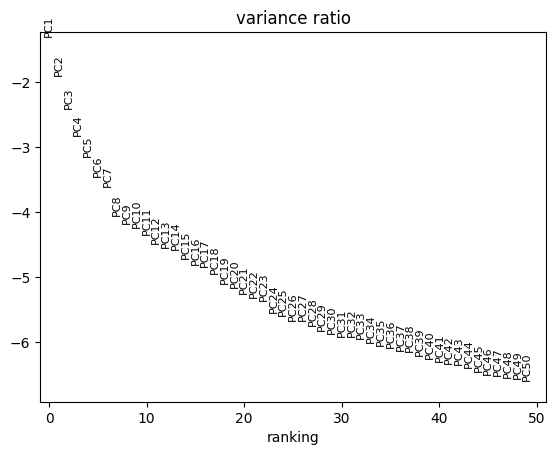

First 30 PCs explain 0.8475165639072086 of variance


In [81]:
X_pca = sc.pp.pca(adata, n_comps=50) 

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) 

print(f"First 30 PCs explain {np.sum(adata.uns['pca']['variance_ratio'][:30])} of variance")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


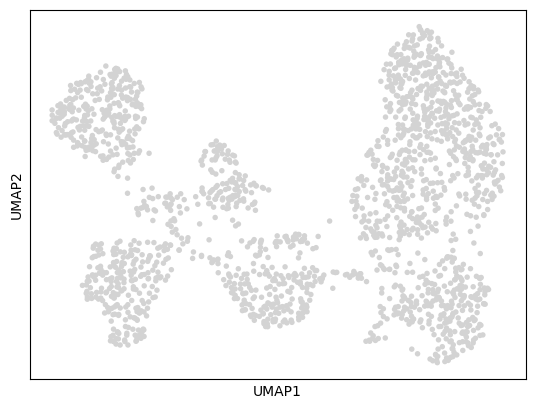

In [82]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [83]:
annotations = pd.read_csv("droplet/annotations_droplet.csv")

/var/folders/sm/phqgwmn54wg8myfr7vsq1vx80000gn/T/ipykernel_78982/4201581835.py:1: DtypeWarning: Columns (10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv("droplet/annotations_droplet.csv")


In [84]:
annotations['cell_id'] = annotations['cell'].str[-16:]
adata.obs['cell_id'] = adata.obs.index.str[:-2]

In [85]:
annotations = annotations[annotations['tissue']=="Mammary_Gland"]

In [86]:
annotations['cell_ontology_class'].unique()
# unique cell types in mammary gland

array(['luminal epithelial cell of mammary gland', 'B cell',
       'stromal cell', 'T cell', 'endothelial cell', 'basal cell',
       'macrophage'], dtype=object)

In [87]:
annotations = annotations[['cell_id', 'cell_ontology_class']]
annotations = annotations[annotations['cell_id'].isin(adata.obs['cell_id'])]
annotations = annotations.drop_duplicates(subset=['cell_id'])

In [88]:
# Assuming you have a pandas DataFrame called 'annotations' with cell annotations
adata.obs = adata.obs.merge(annotations, on='cell_id', how='left')

In [124]:
import lsh
import knn
import importlib
importlib.reload(lsh)
importlib.reload(knn)

<module 'knn' from '/Users/koheisanno/Documents/School/COS521_Final/knn.py'>

In [90]:
pca_data = adata.obsm['X_pca']

In [230]:
pca_data.shape

(1929, 50)

In [91]:
knn_lsh = knn.KNN_LSH(pca_data.shape[1], 7, 120, 700, similarity_metric='jaccard')
knn_lsh.construct_knng(pca_data, 15)

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [93]:
knn_kdt = knn.KNN_KDT(pca_data.shape[1], similarity_metric='jaccard')
knn_kdt.construct_knng(pca_data, 15)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39393939],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.39393939, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [94]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


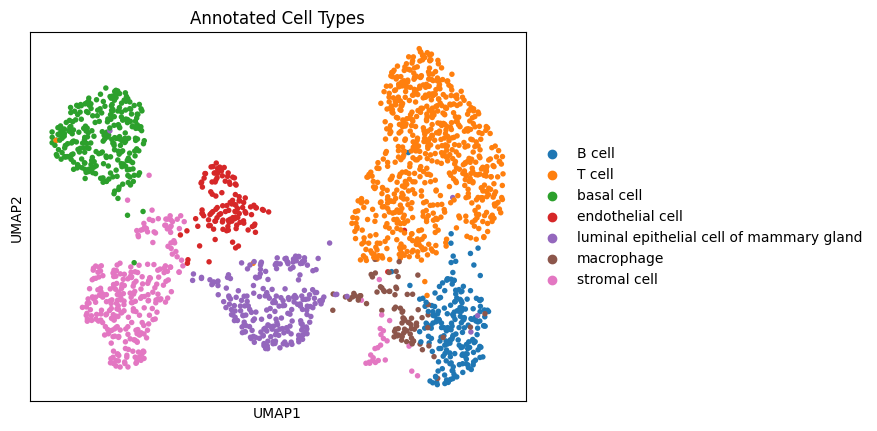

In [160]:
sc.pl.umap(adata, color=["cell_ontology_class"], cmap="tab20", title="Annotated Cell Types")

In [157]:
knn_lsh_7_180 = knn.KNN_LSH(pca_data.shape[1], 7, 180, 700, similarity_metric='jaccard')
knn_lsh_7_80.construct_knng(pca_data, 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


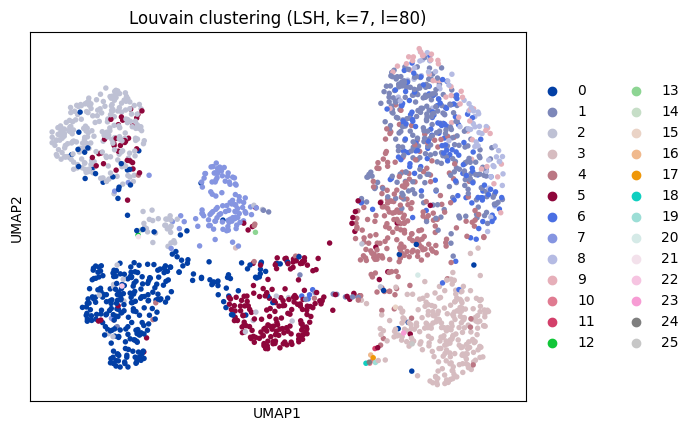

In [158]:
sc.tl.louvain(adata, adjacency=knn_lsh_7_80.sp_adj_matrix, key_added="louvain_lsh_7_80")

sc.pl.umap(adata, color=["louvain_lsh_7_80"], cmap="tab20", title="Louvain clustering (LSH, k=7, l=80)")

In [231]:
knn_lsh_7_180 = knn.KNN_LSH(pca_data.shape[1], 7, 180, 700, similarity_metric='jaccard')
knn_lsh_7_180.construct_knng(pca_data, 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


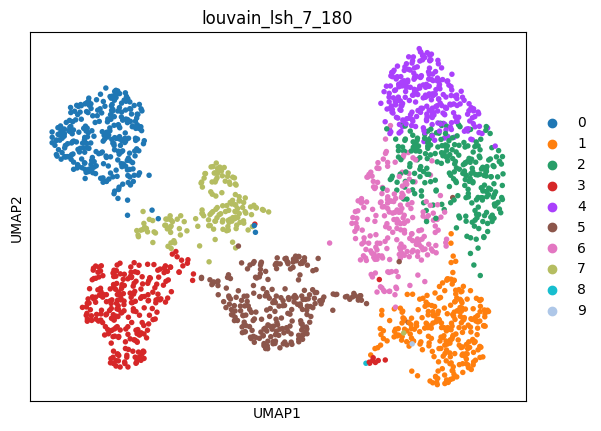

In [187]:
sc.tl.louvain(adata, adjacency=knn_lsh_7_180.sp_adj_matrix, key_added="louvain_lsh_7_180")

sc.pl.umap(adata, color=["louvain_lsh_7_180"], cmap="tab20")

In [190]:
import utils
importlib.reload(utils)
adata = utils.adj_clusters(adata, 'louvain_lsh_7_180', [('2', '4', '6')])

('2', '4', '6')
louvain_lsh_7_180_adj


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


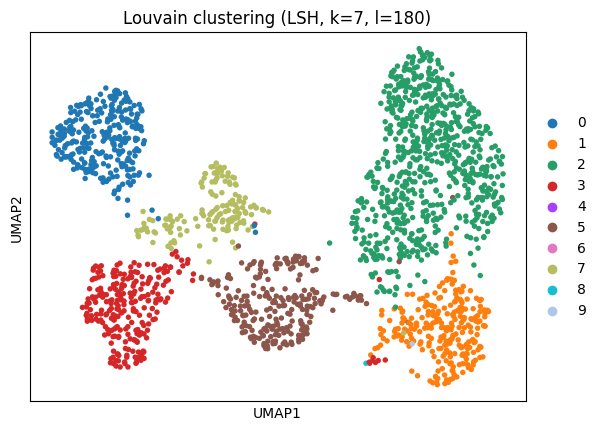

0.8913627070977346


In [191]:
sc.pl.umap(adata, color=["louvain_lsh_7_180_adj"], cmap="tab20", title="Louvain clustering (LSH, k=7, l=180)")

from sklearn.metrics.cluster import adjusted_rand_score

print(adjusted_rand_score(adata.obs['louvain_lsh_7_180_adj'], adata.obs['cell_ontology_class']))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


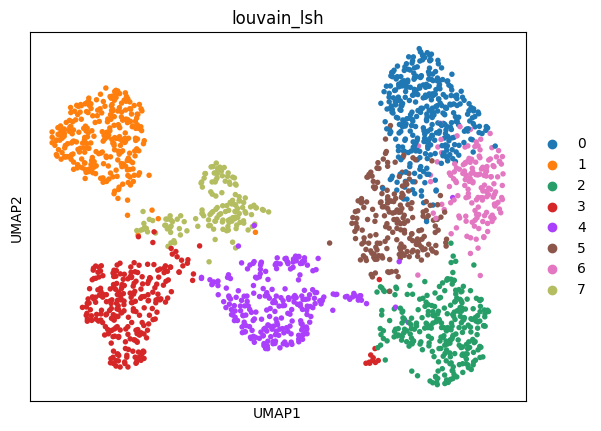

In [113]:
sc.tl.louvain(adata, adjacency=knn_lsh.sp_adj_matrix, key_added="louvain_lsh")

sc.pl.umap(adata, color=["louvain_lsh"], cmap="tab20")

In [229]:
knn_kdt = knn.KNN_KDT(pca_data.shape[1], similarity_metric='jaccard')
knn_kdt.construct_knng(pca_data, 15)

In [225]:
knn_brute = knn.KNN_Brute(pca_data.shape[1], similarity_metric='jaccard')
knn_brute.construct_knng(pca_data, 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


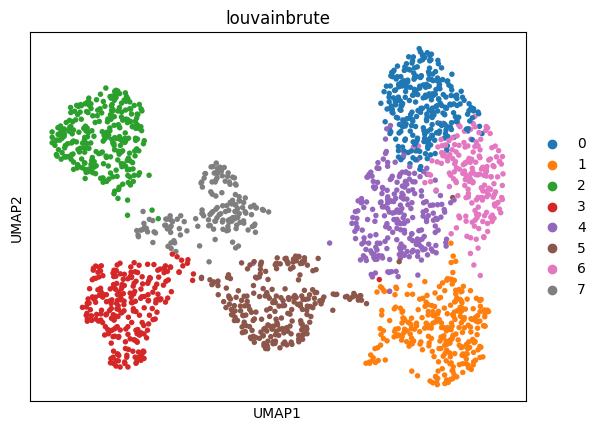

In [226]:
sc.tl.louvain(adata, adjacency=knn_brute.sp_adj_matrix, key_added="louvainbrute")
sc.pl.umap(adata, color=["louvainbrute"], cmap="tab20")

In [227]:
import utils
importlib.reload(utils)
adata = utils.adj_clusters(adata, 'louvainbrute', [('0', '4', '6')])

('0', '4', '6')
louvainbrute_adj


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


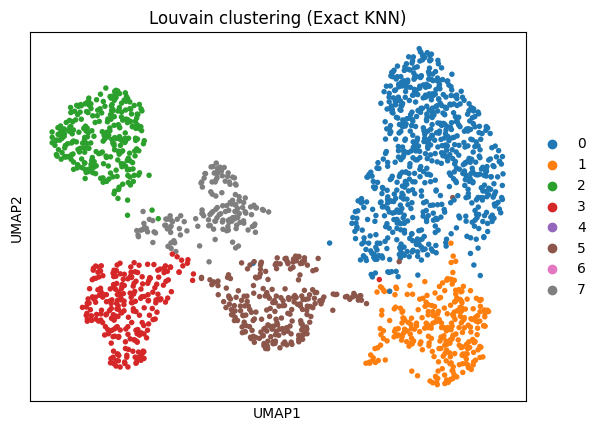

0.8952255002294341


In [228]:
sc.pl.umap(adata, color=["louvainbrute_adj"], cmap="tab20", title="Louvain clustering (Exact KNN)")

from sklearn.metrics.cluster import adjusted_rand_score

print(adjusted_rand_score(adata.obs['louvainbrute_adj'], adata.obs['cell_ontology_class']))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


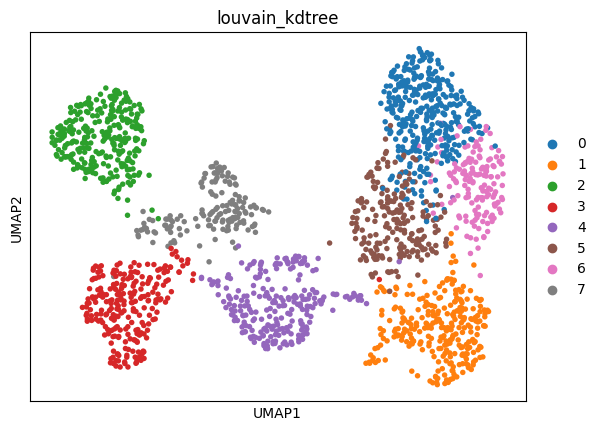

In [98]:
sc.tl.louvain(adata, adjacency=knn_kdt.sp_adj_matrix, key_added="louvain_kdtree")

sc.pl.umap(adata, color=["louvain_kdtree"], cmap="tab20")

In [99]:
adata.obs['louvain_lsh_adj'] = adata.obs['louvain_lsh']
adata.obs['louvain_lsh_adj'][np.logical_or(adata.obs['louvain_lsh_adj'] == '4', adata.obs['louvain_lsh_adj'] == '6')] = '1'

In [100]:
adata.obs['louvain_kdtree_adj'] = adata.obs['louvain_kdtree']
adata.obs['louvain_kdtree_adj'][np.logical_or(adata.obs['louvain_kdtree_adj'] == '5', adata.obs['louvain_kdtree_adj'] == '6')] = '0'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


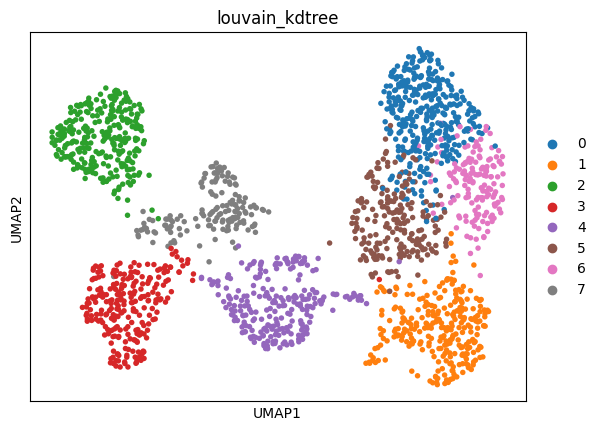

In [101]:
# adjust clusters
sc.pl.umap(adata, color=["louvain_kdtree"], cmap="tab20")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


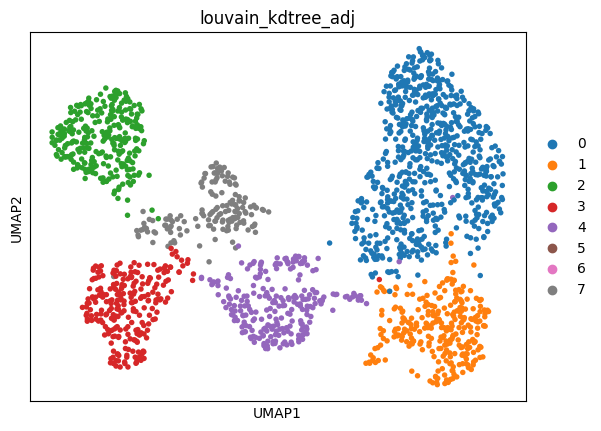

In [156]:
sc.pl.umap(adata, color=["louvain_kdtree_adj"], cmap="tab20")

In [102]:
adata.obs['cell_ontology_class_adj'] = adata.obs['cell_ontology_class']
adata.obs['cell_ontology_class_adj'][adata.obs['cell_ontology_class_adj'] == 'macrophage'] = 'B cell'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


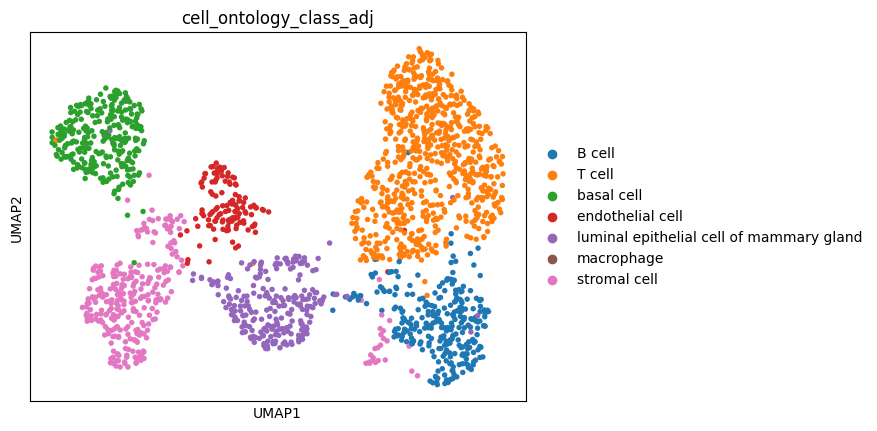

In [103]:
sc.pl.umap(adata, color=["cell_ontology_class_adj"], cmap="tab20")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


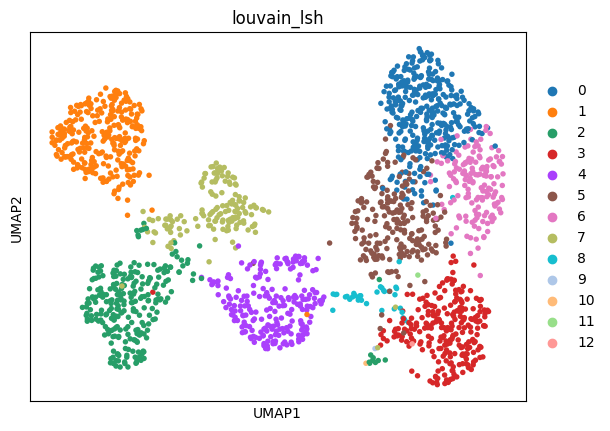

In [104]:
sc.pl.umap(adata, color=["louvaina_lsh"], cmap="tab20")

In [105]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(adata.obs['louvain_lsh'], adata.obs['cell_ontology_class'])

0.621200160317819

In [135]:
from sklearn.metrics.cluster import adjusted_rand_score

print(adjusted_rand_score(adata.obs['louvain_lsh_7_80'], adata.obs['cell_ontology_class']))
print(adjusted_rand_score(adata.obs['louvain_kdtree_adj'], adata.obs['cell_ontology_class_adj']))

0.6131880660963668
0.9096901499264235
